In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
#import our dataset
df = pd.read_csv('mnist_test.csv')
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#make it into floats
data = df.astype(float)

In [4]:
#separate data domain from label set
x = data.drop(["label"], axis=1).values / 255
y = data[["label"]].values

In [5]:
# One-Hot ENCODING of the target variable y
ohe = OneHotEncoder(sparse=False)

#random permutation of training and test set
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)

In [6]:
y_train = ohe.fit_transform(y_train)

# Make the 0's into -1's because of binary label set (Y = {-1, 1})
y_train[y_train != 1] = -1

In [7]:
n_samples = len(x_train)

In [8]:
# Define kernel function for readibility: second order
def polynomial_kernel_2(x, y, p=2):
    return (1 + np.dot(x, y)) ** p

In [9]:
### INITIALIZE WHOLE KERNEL MATRIX      ---------------------------------- ALREADY DONE

# Initialize kernel for RAM stuff
#K = np.zeros((n_samples, n_samples))

In [10]:
# MATRIX FOR DEGREE 2

# Generate complete kernel (also for right data)

#print(datetime.now())
#start = datetime.now()

#for i in range(n_samples):

#    for j in range(n_samples):
        
#        K[i,j] = polynomial_kernel_2(x_train[i], x_train[j])

#stop = datetime.now()
#print(stop - start)

In [11]:
#np.savetxt('KERNEL-MATRIX-2.txt', K, delimiter=',')

In [12]:
# Load the MATRIX of the KERNELS created above
# 12 seconds to load each one = total 12x5 = 60 --> less than 1 min

kernel_2 = pd.read_csv('KERNEL-MATRIX-2.txt', header = None)

In [13]:
k2 = kernel_2.to_numpy()

In [14]:
#set up n. of digits and epochs
digits = 10
total_epochs = 20

S_2 = [] 
#initialize an empty list to which we are going to append the number of mistakes for each example of each digit
#one item for each epochs' running

In [15]:
## TRAIN for KERNEL 2  - it needs 10 minutes

start = datetime.now()
#for each epoch's running
for E in range(1, total_epochs+1):
    
    #create the item to be appended at the end of each epoch
    #mistakes_2 will be the matrix of how many times each datapoint is mistaken
    mistakes_2 = np.zeros(((n_samples), digits))
    for classification_label in range(digits):
        
        #running E times
        for epoch in range(E): #the loop over the epochs 1, then 2, ..., then 10
            #create the prediction's object, a prediction for each datapoint
            y_hat = np.zeros(n_samples) #the prediction for each datapoint in the training set
            # for the stream of datapoints in training set S
            
            for i in range(n_samples):
                #kernel perceptron algorithm training
                y_hat[i] = np.sign(np.sum(k2[:, i] * y_train[:, classification_label] * mistakes_2[:, classification_label]))            
            counter = 0
            
            for prediction in y_hat:
                #when prediction is wrong add one to the mistakes
                if prediction != y_train[counter, classification_label]:
                    mistakes_2[counter, classification_label] += 1.0
                counter += 1

    S_2.append(mistakes_2[:, :])

stop = datetime.now()
print(stop-start)

0:10:23.091837


In [16]:
#create the collection of the predictions, one item for each digit
ensemble_of_predictions = []

for classification_label in range(digits):
    
    #create the object with the predictions
    predictions = np.zeros((n_samples, total_epochs))
    for epoch in range(total_epochs):
    
        for i in range(n_samples):
            
            #make the prediction
            predictions[i, epoch] = np.sign(np.sum(k2[:, i] * y_train[:, classification_label] * S_2[epoch][:, classification_label]))            
    
    #append the 10 items
    ensemble_of_predictions.append(predictions)

In [17]:
#compute the training error for each digit, anche check how it behaves for the different epochs 
training_error_2 = np.zeros((total_epochs, digits))
for digit in range(digits):
    
    #create the vector for each digit
    training_error = np.zeros(total_epochs)
    for epoch in range(total_epochs):
        
        misclassification = 0
        for i in range(n_samples):
            
            #count how many times it is different from the true one
            if ensemble_of_predictions[digit][i][epoch] != y_train[i, digit]: 
                misclassification += 1
        
        training_error[epoch] = misclassification/n_samples
    
    #put the vector in each column, one for each digit
    training_error_2[:, digit] = training_error

In [18]:
#20 rows for the 20 epochs
#10 columns for the digits
training_error_2.shape 

(20, 10)

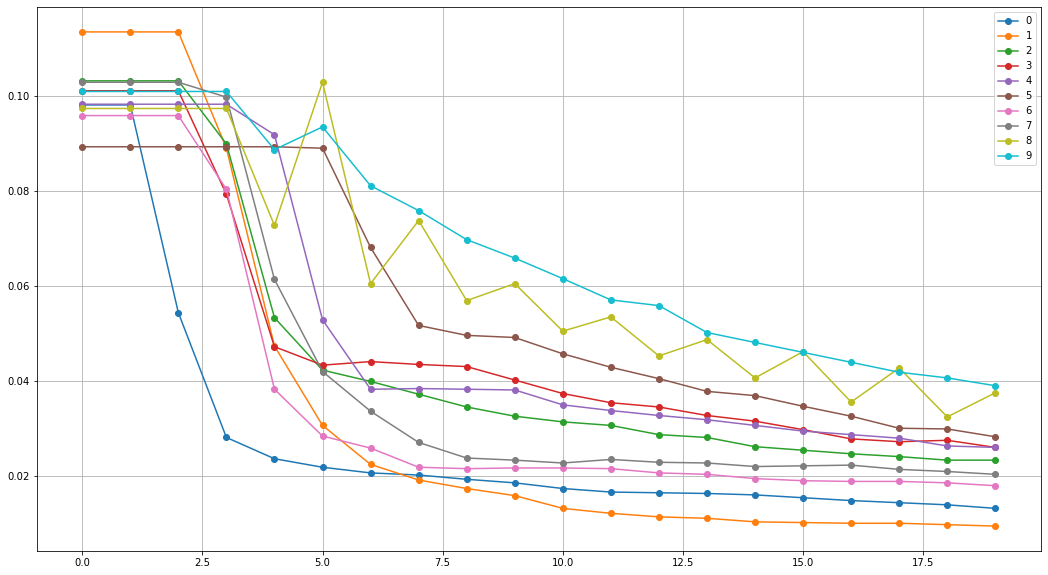

In [20]:
#plot the training error
plt.figure(figsize=(18,10))
for digit in range(digits):
    plt.plot(training_error_2[:,digit], '-o', label=str(digit))
plt.legend()
plt.grid()

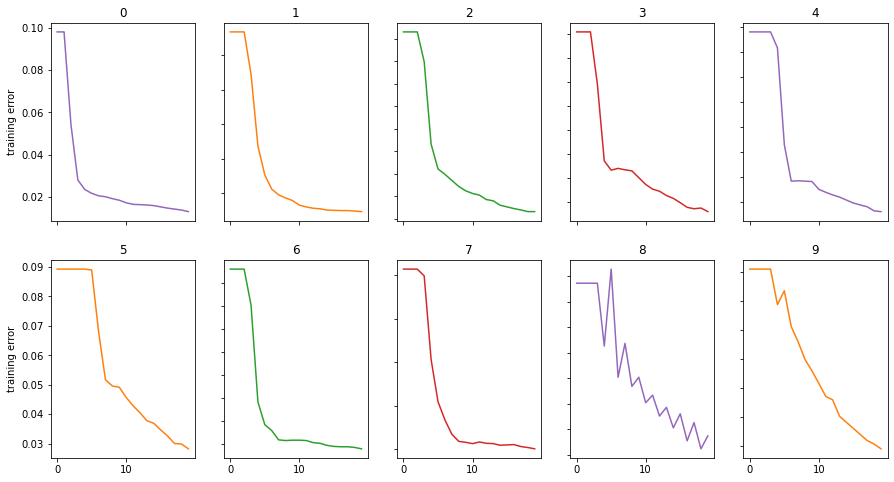

In [51]:
fig, axs = plt.subplots(2, 5)
fig.set_figheight(8)
fig.set_figwidth(15)

axs[0, 0].plot(training_error_2[:,0], 'tab:purple')
axs[0, 0].set_title('0')

axs[0, 1].plot(training_error_2[:,1], 'tab:orange')
axs[0, 1].set_title('1')

axs[0, 2].plot(training_error_2[:,2], 'tab:green')
axs[0, 2].set_title('2')

axs[0, 3].plot(training_error_2[:,3], 'tab:red')
axs[0, 3].set_title('3')

axs[0, 4].plot(training_error_2[:,4], 'tab:purple')
axs[0, 4].set_title('4')

axs[1, 0].plot(training_error_2[:,5], 'tab:orange')
axs[1, 0].set_title('5')

axs[1, 1].plot(training_error_2[:,6], 'tab:green')
axs[1, 1].set_title('6')

axs[1, 2].plot(training_error_2[:,7], 'tab:red')
axs[1, 2].set_title('7')

axs[1, 3].plot(training_error_2[:,8], 'tab:purple')
axs[1, 3].set_title('8')

axs[1, 4].plot(training_error_2[:,9], 'tab:orange')
axs[1, 4].set_title('9')



for ax in axs.flat:
    ax.set(xlabel='', ylabel='training error')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [52]:
#compute the training error on the unique prediction
total_training_error_2 = np.zeros(total_epochs)

for epoch in range(total_epochs):
    
    #create the prediction object for each epoch
    predictions = np.zeros((n_samples, digits))
    for classification_label in range(digits):

        for i in range(n_samples):

            predictions[i, classification_label] = np.sign(np.sum(k2[:, i] * y_train[:, classification_label] * S_2[epoch][:, classification_label]))            

    y_hat = np.zeros(n_samples)

    for i in range(n_samples):

        if predictions[i].argmax() != y_train[i].argmax():

            y_hat[i] = 1.0
    
    #compute the mean between the 0s-1s in the prediction vector (prediction of each datapoint's label)
    total_training_error_2[epoch] = np.mean(y_hat)

In [53]:
total_training_error_2

array([0.9019403 , 0.9019403 , 0.9019403 , 0.8238806 , 0.55776119,
       0.36089552, 0.30985075, 0.25268657, 0.23791045, 0.21985075,
       0.20880597, 0.19761194, 0.19149254, 0.18119403, 0.17537313,
       0.16507463, 0.16298507, 0.15313433, 0.15313433, 0.14402985])

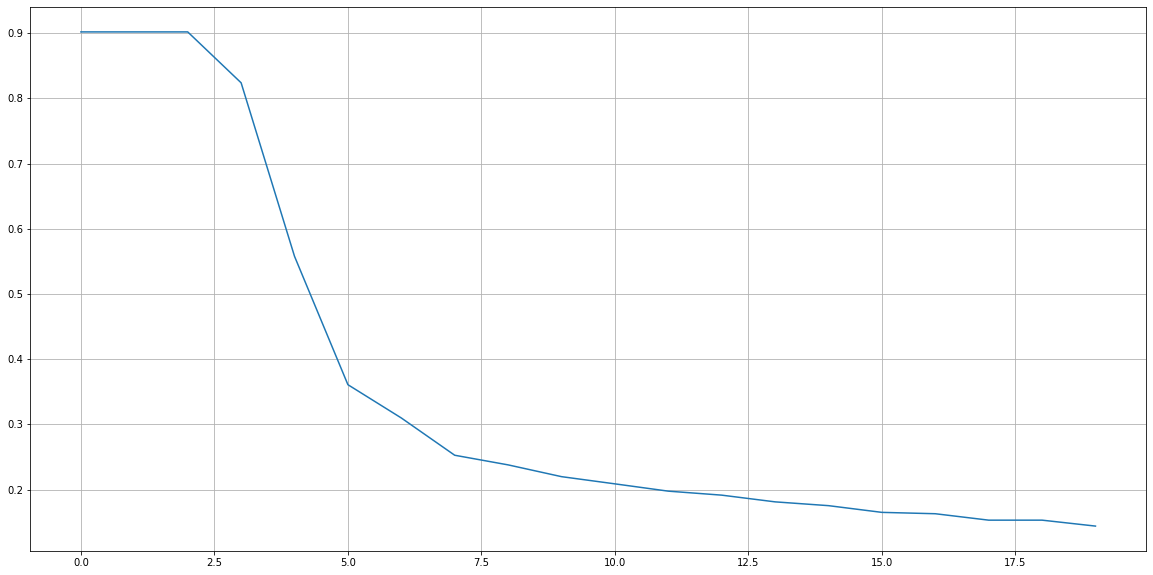

In [54]:
plt.figure(figsize=(20,10))
plt.plot(total_training_error_2)
plt.grid()

In [55]:
#SAVE the list of mistakes
#np.save("S_2.npy", np.array(S_2))
S_2 = np.load('S_2.npy')

In [56]:
#CREATE the object with the average of predictors among the epochs
#avg_S_2 = np.zeros((n_samples, 10))
#for epoch in range(total_epochs):
#    avg_S_2 = avg_S_2 + np.array(S_2[epoch][:])
#avg_S_2 = avg_S_2/total_epochs

In [57]:
#np.savetxt('avg_S_2.txt', np.array(avg_S_2), delimiter=',')

avg_S_2 = pd.read_csv('avg_S_2.txt', header = None)
avg_S_2 = avg_S_2.to_numpy()

In [58]:
#SAVE the object TRAINING and Total training error
#np.savetxt('total_training_error_2.txt', total_training_error_2, delimiter=',')
#np.savetxt('training_error_2.txt', training_error_2, delimiter=',')

In [59]:
training_error_2 = pd.read_csv('training_error_2.txt', header = None)
training_error_2 = training_error_2.to_numpy()

total_training_error_2 = pd.read_csv('total_training_error_2.txt', header = None)
total_training_error_2 = total_training_error_2.to_numpy()

In [62]:
#Just choose 20 epochs for all the digits
for digit in range(10):
    print("N. of epochs to choose for digit", digit, ":     ", training_error_2[:, digit].argmin()+1)

N. of epochs to choose for digit 0 :      20
N. of epochs to choose for digit 1 :      20
N. of epochs to choose for digit 2 :      19
N. of epochs to choose for digit 3 :      20
N. of epochs to choose for digit 4 :      20
N. of epochs to choose for digit 5 :      20
N. of epochs to choose for digit 6 :      20
N. of epochs to choose for digit 7 :      20
N. of epochs to choose for digit 8 :      19
N. of epochs to choose for digit 9 :      20


In [63]:
#create object zero-one-loss for the mistaken points in test
zero_one_loss = np.zeros((len(x_test), total_epochs))

In [64]:
## TEST with the predictor with the min training error --- for the different epochs
## 20 minutes running
start = datetime.now()
for k in range(total_epochs):

    # for the stream of datapoints in training set
    counter = 0

    for x in x_test:

        y_hat = np.zeros(10)

        for classification_label in range(10):


            y_hat[classification_label] = np.sign(np.sum(polynomial_kernel_2(x_train[:,:], x) * y_train[:, classification_label] * S_2[k][:, classification_label]))


        if y_hat.argmax() != y_test[counter]:
            zero_one_loss[counter, k] = 1.0
        counter += 1

stop = datetime.now()
print(stop-start)

0:19:58.982616


In [65]:
test_error_2 = np.zeros(total_epochs)
for k in range(total_epochs):
    test_error_2[k] = np.mean(zero_one_loss[:,k])

In [66]:
#np.savetxt('test_error_2.txt', np.array(test_error_2), delimiter=',')

In [67]:
test_error_2 = pd.read_csv('test_error_2.txt', header = None)
test_error_2 = test_error_2.to_numpy()

In [68]:
test_error_2

array([[0.90212121],
       [0.90212121],
       [0.90212121],
       [0.82848485],
       [0.56727273],
       [0.36969697],
       [0.31909091],
       [0.25848485],
       [0.24666667],
       [0.22636364],
       [0.21727273],
       [0.20424242],
       [0.19848485],
       [0.18787879],
       [0.18030303],
       [0.17212121],
       [0.17333333],
       [0.16363636],
       [0.16      ],
       [0.15424242]])

In [69]:
#the epoch to pick is:
test_error_2.argmin()+1

20

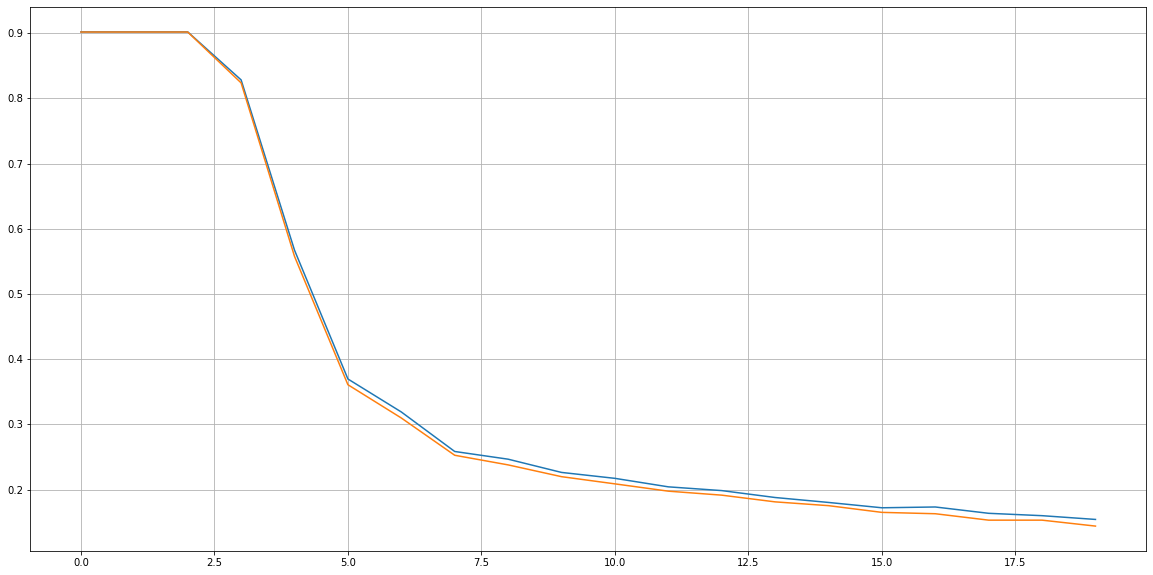

In [70]:
plt.figure(figsize=(20,10))
plt.plot(test_error_2)
plt.plot(total_training_error_2)
plt.grid()

In [73]:
## TEST with the AVERAGE of the predictors
zero_one_loss = np.zeros(len(x_test))

# for the stream of datapoints in training set
        
a = datetime.now()

counter = 0

for x in x_test:

    y_hat = np.zeros(10)

    for classification_label in range(10):


        y_hat[classification_label] = np.sign(np.sum(polynomial_kernel_2(x_train[:,:], x) * y_train[:, classification_label] * avg_S_2[:, classification_label]))


    if y_hat.argmax() != y_test[counter]:
        zero_one_loss[counter] = 1.0
    counter += 1

b = datetime.now()
print(b-a)

0:00:40.921068


In [74]:
zero_one_loss, zero_one_loss.shape

(array([1., 1., 1., ..., 1., 0., 1.]), (3300,))

In [75]:
np.mean(zero_one_loss)

0.48878787878787877